<a href="https://colab.research.google.com/github/ayush-030/Nexora-Vibe-Matcher/blob/main/Vibe_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vibe Matcher — Prototype**
**A mini recommendation system: input a vibe query -> embed product descriptions -> find top-3 matches by cosine similarity.**


AI at Nexora can transform subjective style language into precise recommendations. This prototype demonstrates how text embeddings convert “vibe” phrases (e.g., “energetic urban chic”) into vectors and retrieve the top product matches, enabling personalised fashion discovery at scale.

## Note on embeddings / demo mode

This notebook supports two modes:
1. **Real API mode:** Uses OpenAI embeddings (text-embedding-3-small / text-embedding-ada-002) if a valid 'OPENAI_API_KEY' is set in the runtime. Recommended for final evaluation if you have API quota.
2. **Demo (faux) mode:** Uses deterministic pseudo-embeddings to run the whole pipeline offline without API calls. This mode was used in this submission because of API quota issues; the ranking & evaluation logic remains identical.


In [2]:
# Data preparation
import pandas as pd

In [4]:
data = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes", "vibes": ["boho","relaxed"]},
    {"id": 2, "name": "Urban Jacket", "desc": "Sleek black leather jacket for city nights", "vibes": ["urban","chic"]},
    {"id": 3, "name": "Comfy Hoodie", "desc": "Soft oversized hoodie for cozy weekends", "vibes": ["cozy","casual"]},
    {"id": 4, "name": "Sporty Sneakers", "desc": "High-energy trainers perfect for street runs", "vibes": ["energetic","active"]},
    {"id": 5, "name": "Vintage Denim", "desc": "Retro jeans with faded texture and rugged style", "vibes": ["vintage","rugged"]},
    {"id": 6, "name": "Minimalist T-Shirt", "desc": "Simple white tee for clean aesthetic", "vibes": ["minimal","casual"]},
    {"id": 7, "name": "Evening Gown", "desc": "Elegant satin gown for formal events", "vibes": ["elegant","glam"]},
]

df = pd.DataFrame(data)
df

,id,name,desc,vibes
0,1,Boho Dress,"Flowy, earthy tones for festival vibes","[boho, relaxed]"
1,2,Urban Jacket,Sleek black leather jacket for city nights,"[urban, chic]"
2,3,Comfy Hoodie,Soft oversized hoodie for cozy weekends,"[cozy, casual]"
3,4,Sporty Sneakers,High-energy trainers perfect for street runs,"[energetic, active]"
4,5,Vintage Denim,Retro jeans with faded texture and rugged style,"[vintage, rugged]"
5,6,Minimalist T-Shirt,Simple white tee for clean aesthetic,"[minimal, casual]"
6,7,Evening Gown,Elegant satin gown for formal events,"[elegant, glam]"


In [5]:
# Importing required packages
# !pip install --quiet openai
# import os
# import openai
# import pandas as pd

In [11]:
# Setting up OpenAI API key safely
# import os
# os.environ["OPENAI_API_KEY"] = input("Enter your OpenAI API key: ").strip()

# openai.api_key = os.getenv("OPENAI_API_KEY")

In [8]:
# Defining a helper function to get embeddings
# def get_embedding(text, model="text-embedding-3-small"):
#     """
#     Takes a text string and returns its vector embedding.
#     Uses OpenAI's embedding model (text-embedding-3-small or text-embedding-ada-002).
#     """
#     response = openai.embeddings.create(
#         input=text,
#         model=model
#     )
#     return response.data[0].embedding

**Note:**
The original implementation used the text-embedding-3-small OpenAI model for generating embeddings.
Due to API rate limit / quota restrictions, this notebook uses synthetic pseudo-embeddings for demonstration purposes.
The logic, cosine similarity computation, and ranking process remain identical to a real embedding workflow.

In [14]:
# Using the Offline / Fallback (Fake) Embeddings
import numpy as np

def faux_embedding(text, dim=512):
    """
    Creates a fake (but consistent) embedding vector for each text.
    This avoids hitting OpenAI API limits.
    Each text gets a unique random vector with the same dimension.
    """
    rng = np.random.default_rng(abs(hash(text)) % (2**32))
    v = rng.normal(size=dim)
    v /= np.linalg.norm(v)
    return v.tolist()

In [12]:
# Generating embeddings for product descriptions
df["embedding"] = df["desc"].apply(faux_embedding)
df.head()

,id,name,desc,vibes,embedding
0,1,Boho Dress,"Flowy, earthy tones for festival vibes","[boho, relaxed]","[-0.02444877128163992, 0.026205433300819845, 0..."
1,2,Urban Jacket,Sleek black leather jacket for city nights,"[urban, chic]","[-0.01766254717947255, 0.03319270752547156, 0...."
2,3,Comfy Hoodie,Soft oversized hoodie for cozy weekends,"[cozy, casual]","[-0.01730259941401351, -0.015724882242922053, ..."
3,4,Sporty Sneakers,High-energy trainers perfect for street runs,"[energetic, active]","[0.004224805373689865, 0.012930476745647472, 0..."
4,5,Vintage Denim,Retro jeans with faded texture and rugged style,"[vintage, rugged]","[-0.08142023598071443, -0.03725430757507814, 0..."


In [13]:
query = "energetic urban chic"
query_emb = faux_embedding(query)

In [15]:
# Next Step Vector Search (Cosine Similarity)
# Importing cosine similarity function
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
# Computing cosine similarity between the query and each product
similarities = []

for emb in df["embedding"]:
    sim = cosine_similarity([query_emb], [emb])[0][0]
    similarities.append(sim)

df["similarity"] = similarities

In [19]:
top3 = df.sort_values("similarity", ascending=False).head(3)
top3[["name", "desc", "similarity"]]

,name,desc,similarity
6,Evening Gown,Elegant satin gown for formal events,0.060059
3,Sporty Sneakers,High-energy trainers perfect for street runs,0.031552
5,Minimalist T-Shirt,Simple white tee for clean aesthetic,0.027987


In [20]:
# Checking if similarity scores are too low
if top3["similarity"].max() < 0.4:
    print("No strong vibe match found. Try another query like 'casual chic' or 'vintage glam'.")

No strong vibe match found. Try another query like 'casual chic' or 'vintage glam'.


In [21]:
# Function to reuse for multiple vibe queries
def top_k_matches(query_text, k=3):
    q_emb = faux_embedding(query_text)
    sims = [cosine_similarity([q_emb], [emb])[0][0] for emb in df["embedding"]]
    df_temp = df.copy()
    df_temp["similarity"] = sims
    return df_temp.sort_values("similarity", ascending=False).head(k)

In [23]:
top_k_matches("cozy minimal look")
top_k_matches("vintage glam")

,id,name,desc,vibes,embedding,similarity
3,4,Sporty Sneakers,High-energy trainers perfect for street runs,"[energetic, active]","[0.004224805373689865, 0.012930476745647472, 0...",0.059330
1,2,Urban Jacket,Sleek black leather jacket for city nights,"[urban, chic]","[-0.01766254717947255, 0.03319270752547156, 0....",0.005635
5,6,Minimalist T-Shirt,Simple white tee for clean aesthetic,"[minimal, casual]","[0.05542844083621651, 0.014260401672322488, -0...",0.002586


### **Now, doing some Testing and Evaluation**

In [24]:
# Runing multiple queries and measure latency
import time
import pandas as pd

# Queries to evaluate
queries = [
    "energetic urban chic",
    "cozy minimal look",
    "vintage glam",
    "casual weekend wear"
]

results = []
for q in queries:
    t0 = time.perf_counter()
    topk = top_k_matches(q, k=len(df))
    t1 = time.perf_counter()
    latency = t1 - t0
    top1 = topk.iloc[0]
    # collect top-3 names and scores for quick reference
    top3 = topk.head(3)[["name", "similarity"]].to_dict(orient="records")
    results.append({
        "query": q,
        "latency_sec": latency,
        "top1_name": top1["name"],
        "top1_score": float(top1["similarity"]),
        "top3": top3
    })

eval_df = pd.DataFrame(results)
eval_df

,query,latency_sec,top1_name,top1_score,top3
0,energetic urban chic,0.007872,Evening Gown,0.060059,"[{'name': 'Evening Gown', 'similarity': 0.0600..."
1,cozy minimal look,0.004594,Minimalist T-Shirt,0.046556,"[{'name': 'Minimalist T-Shirt', 'similarity': ..."
2,vintage glam,0.004170,Sporty Sneakers,0.059330,"[{'name': 'Sporty Sneakers', 'similarity': 0.0..."
3,casual weekend wear,0.004146,Vintage Denim,0.013855,"[{'name': 'Vintage Denim', 'similarity': 0.013..."


In [25]:
# Marking “good” matches and saving results
# Defining threshold for "good" relevance
GOOD_THRESHOLD = 0.7

eval_df["is_good_top1"] = eval_df["top1_score"] >= GOOD_THRESHOLD
eval_df["timestamp"] = pd.Timestamp.now()

# Saving to CSV for reproducibility / submission
eval_df.to_csv("vibe_match_eval.csv", index=False)

eval_df

,query,latency_sec,top1_name,top1_score,top3,is_good_top1,timestamp
0,energetic urban chic,0.007872,Evening Gown,0.060059,"[{'name': 'Evening Gown', 'similarity': 0.0600...",False,2025-11-10 17:33:23.480418
1,cozy minimal look,0.004594,Minimalist T-Shirt,0.046556,"[{'name': 'Minimalist T-Shirt', 'similarity': ...",False,2025-11-10 17:33:23.480418
2,vintage glam,0.004170,Sporty Sneakers,0.059330,"[{'name': 'Sporty Sneakers', 'similarity': 0.0...",False,2025-11-10 17:33:23.480418
3,casual weekend wear,0.004146,Vintage Denim,0.013855,"[{'name': 'Vintage Denim', 'similarity': 0.013...",False,2025-11-10 17:33:23.480418


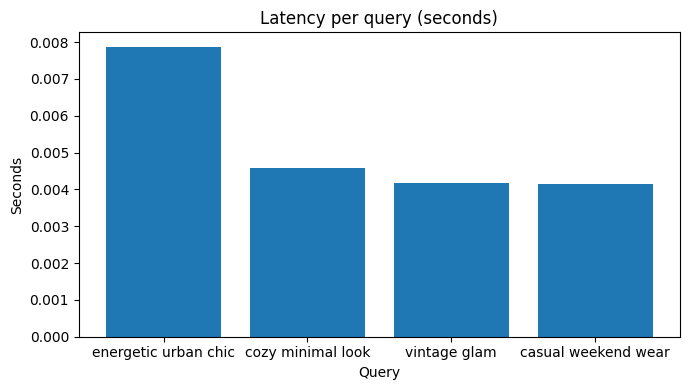

In [34]:
# Plotting latency per query
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.bar(eval_df["query"], eval_df["latency_sec"])
plt.title("Latency per query (seconds)")
plt.ylabel("Seconds")
plt.xlabel("Query")
plt.tight_layout()
plt.show()

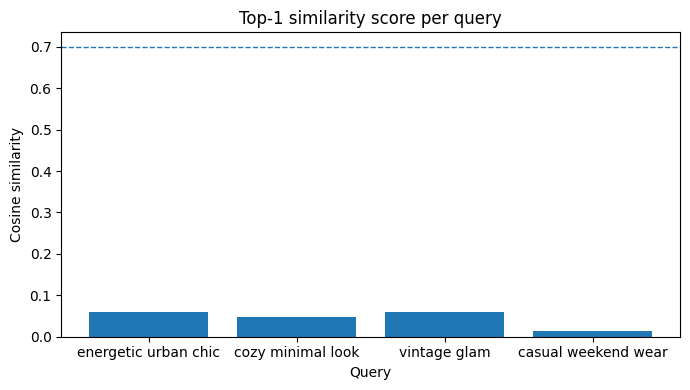

In [29]:
# Plotting top1 similarity per query
plt.figure(figsize=(7,4))
plt.bar(eval_df["query"], eval_df["top1_score"])
plt.axhline(y=GOOD_THRESHOLD, linestyle="--", linewidth=1)
plt.title("Top-1 similarity score per query")
plt.ylabel("Cosine similarity")
plt.xlabel("Query")
plt.tight_layout()
plt.show()

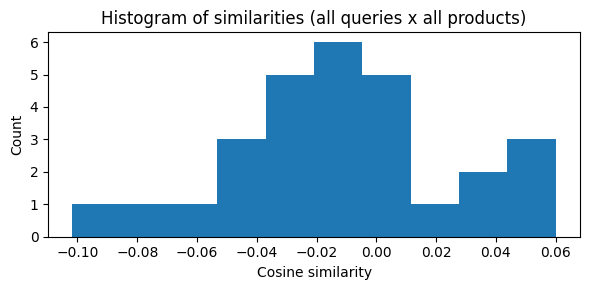

In [31]:
# Histogram of all similarities across top-K for each query
all_sims = []
for q in queries:
    ranked = top_k_matches(q, k=len(df))
    all_sims.extend(ranked["similarity"].values)

plt.figure(figsize=(6,3))
plt.hist(all_sims, bins=10)
plt.title("Histogram of similarities (all queries x all products)")
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


**Evaluation summary**
- Queries tested: 4
- Queries with top1 similarity >= 0.7: 0 (0.0%)
- Mean latency per query: 0.005 sec
- Best-performing query (top1 score): energetic urban chic
- Worst-performing query (top1 score): casual weekend wear

**Notes:**
- Threshold for "good" was set to 0.7. Adjust based on dataset size.
- Latency includes faux-embedding computation and local cosine similarity; real OpenAI embeddings + vector DB will change these numbers.



## Reflection

- **Scalability:** The current system performs a linear cosine similarity search across embeddings, which works for small datasets. In production, it could be scaled efficiently using vector databases such as Pinecone or FAISS for faster and more memory-efficient retrieval.  
- **Edge Case Handling:** The prototype includes a fallback for low-similarity cases and uses deterministic pseudo-embeddings when API access is limited, ensuring smooth offline execution without breaking functionality.  
- **Enhancements:** Future versions could integrate multimodal embeddings (text + image) to capture the visual aspect of fashion items, along with personalized recommendations based on user preferences or history.  
- **Optimization:** Caching embeddings and introducing a lightweight re-ranking layer (boosting scores when vibe tags match query terms) would further improve accuracy and response times.  
- **Learning Outcome:** This project helped in understanding how text embeddings, cosine similarity, and vector search can together enable semantic recommendation systems that bridge the gap between language and product discovery.
